In [2]:
import tensorflow as tf
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

from pitchfuncs import WMSE
from pitchfuncs import InversePCA
from pitchfuncs import emulator
from pitchfuncs import ns
import pandas as pd
import scipy
import numpy as np
import corner
import time

2024-04-12 14:08:13.958600: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-12 14:08:13.958630: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-12 14:08:13.959629: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-12 14:08:13.964788: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-12 14:08:14.476904: W tensorflow/compiler/tf2

In [3]:
"""
Load in grid
"""

df = pd.read_hdf('/home/oxs235/datastorage/repos_data/ojscutt/pitchfork/data/bob.h5', key='df') #change if accessing from RDS

In [4]:
model = df
model = model[(model['star_age'] >= 4) & (model['star_age'] <= 6)]
model = model[(model['initial_mass'] >= 0.9) & (model['initial_mass'] <= 1.1)]
model = model[(model['initial_Yinit'] >= 0.28) & (model['initial_Yinit'] <= 0.3)]
model = model[(model['initial_Zinit'] >= 0.01) & (model['initial_Zinit'] <= 0.02)]
model = model[(model['initial_MLT'] >= 1.9) & (model['initial_MLT'] <= 2.1)]

model = model.sample(n=1)

inputs = ['initial_mass', 'initial_Zinit', 'initial_Yinit', 'initial_MLT', 'star_age']
outputs = ['radius', 'luminosity', 'surface_Z'] + [f'nu_0_{i+1}' for i in range(5,40)]

model_inps = model[inputs]
model_outs = model[outputs]

model

,initial_mass,initial_Zinit,initial_Yinit,initial_MLT,star_age,radius,luminosity,effective_T,surface_Z,nu_0_4,...,log_nu_0_31_std,log_nu_0_32_std,log_nu_0_33_std,log_nu_0_34_std,log_nu_0_35_std,log_nu_0_36_std,log_nu_0_37_std,log_nu_0_38_std,log_nu_0_39_std,log_nu_0_40_std
5268796,1.06,0.019517,0.3,1.9,4.641509,1.205814,1.54419,5863.602336,0.016986,537.834934,...,0.166691,0.165999,0.166351,0.166172,0.164852,0.162187,0.158765,0.155873,0.154595,0.154591


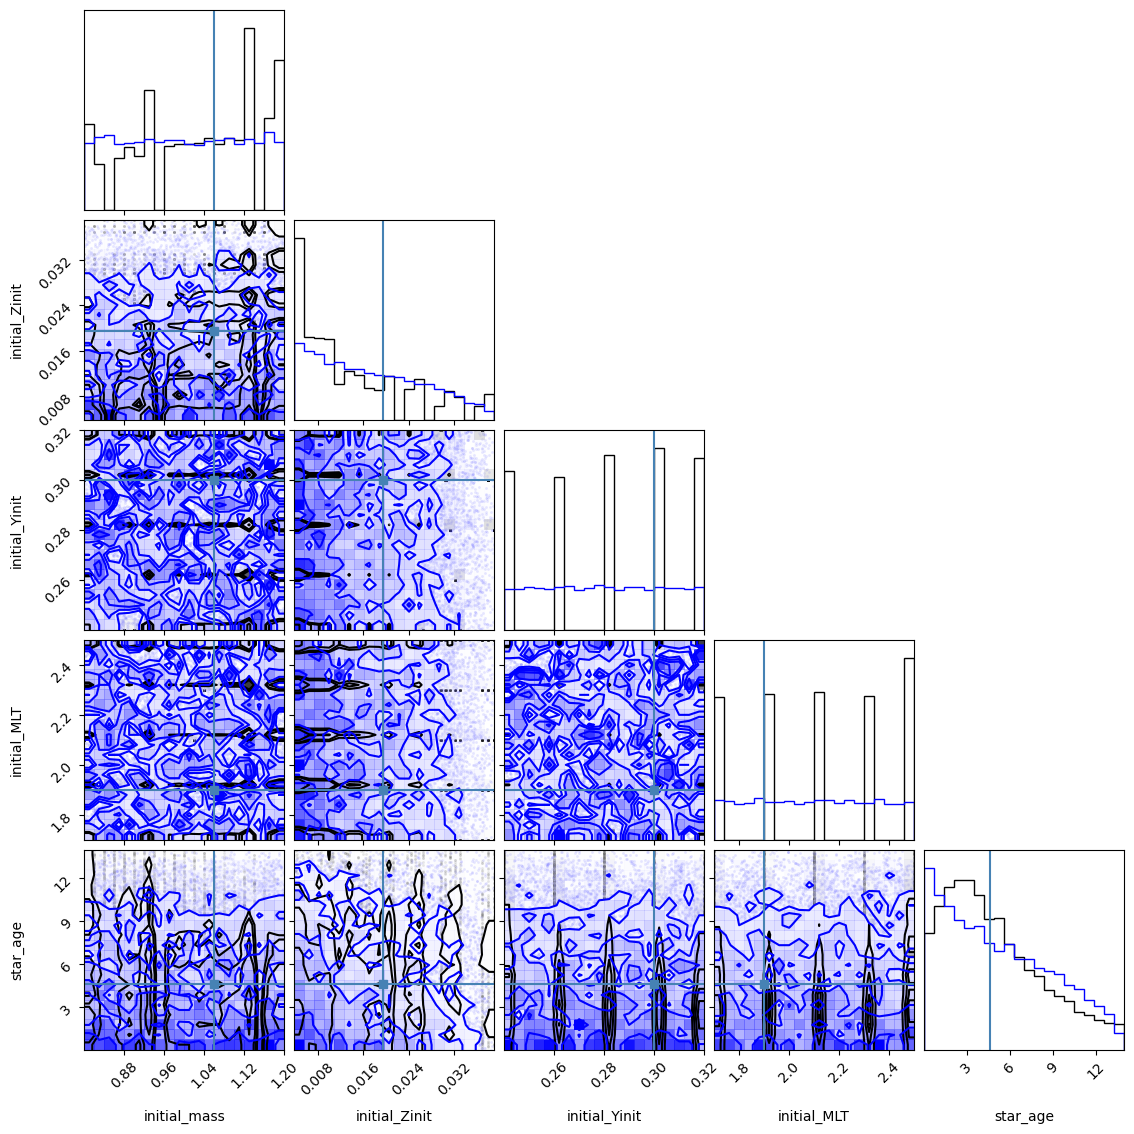

In [5]:
"""
Define priors
"""

def grid_uniform_prior(df, header):
    df_min = df[header].min()
    return scipy.stats.uniform(loc=df_min, scale=df[header].max()-df_min)

def uniform_prior(model_inps, header, scale=0.1):
    model_min = model_inps[header]*(1-scale)
    return scipy.stats.uniform(loc=model_min, scale=(model_inps[header]*(1+scale))-model_min)

def normal_prior(model_inps, header, scale=0.1):
    loc=model_inps[header].values[0]
    return scipy.stats.norm(loc=loc, scale=scale*loc)

def beta_prior(df, header,a=1,b=1):
    df_min = df[header].min()
    return scipy.stats.beta(loc=df_min, scale=df[header].max()-df_min, a=a, b=b)

mass_prior = grid_uniform_prior(df, "initial_mass")

Zinit_prior = beta_prior(df,"initial_Zinit",a=0.9, b=1.5)

Yinit_prior = grid_uniform_prior(df, "initial_Yinit")

MLT_prior = grid_uniform_prior(df, "initial_MLT")

age_prior = beta_prior(df, "star_age", a=0.9, b=1.5)


priors = [mass_prior,Zinit_prior, Yinit_prior, MLT_prior, age_prior]

figure = corner.corner(df[inputs].sample(n=10000), hist_kwargs={'density':True});

prior_samples = np.array([mass_prior.rvs(size=10000),Zinit_prior.rvs(size=10000), Yinit_prior.rvs(size=10000), MLT_prior.rvs(size=10000), age_prior.rvs(size=10000)]).T
corner.corner(prior_samples, truths=model_inps.values.flatten().tolist(), labels=model_inps.columns, color='blue', fig=figure,hist_kwargs={'density':True});

In [6]:
pitchfork = emulator("nu6-40_elu_nonorm")

initial_mass range: [min = 0.8, max = 1.2]
initial_Zinit range: [min = 0.003869061466818601, max = 0.0389797119014747]
initial_Yinit range: [min = 0.24, max = 0.32]
initial_MLT range: [min = 1.7, max = 2.5]
star_age range: [min = 0.029664111540787196, max = 13.999973871651315]


2024-04-12 14:08:20.795460: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-04-12 14:08:20.795482: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:129] retrieving CUDA diagnostic information for host: Bia
2024-04-12 14:08:20.795487: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:136] hostname: Bia
2024-04-12 14:08:20.795586: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:159] libcuda reported version is: 535.171.4
2024-04-12 14:08:20.795603: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] kernel reported version is: 535.161.7
2024-04-12 14:08:20.795608: E external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:244] kernel version 535.161.7 does not match DSO version 535.171.4 -- cannot find working devices in this configuration


In [12]:
"""
Define observed quantities and uncertainties
"""
obs = model_outs.values[0]
unc = np.array([0.04, 0.02, 0.0008] + [.5 + 0.05*(np.abs(i-22))**2 for i in range(5,40)])
# 0.0006 in surface_Z from solar (~4.3%, Asplund 2020), increased to ~6%. Could try 10% too.
unc

array([4.000e-02, 2.000e-02, 8.000e-04, 1.495e+01, 1.330e+01, 1.175e+01,
       1.030e+01, 8.950e+00, 7.700e+00, 6.550e+00, 5.500e+00, 4.550e+00,
       3.700e+00, 2.950e+00, 2.300e+00, 1.750e+00, 1.300e+00, 9.500e-01,
       7.000e-01, 5.500e-01, 5.000e-01, 5.500e-01, 7.000e-01, 9.500e-01,
       1.300e+00, 1.750e+00, 2.300e+00, 2.950e+00, 3.700e+00, 4.550e+00,
       5.500e+00, 6.550e+00, 7.700e+00, 8.950e+00, 1.030e+01, 1.175e+01,
       1.330e+01, 1.495e+01])

In [13]:
"""
add noise to observed quantities
"""
def obs_noise(obs, unc):
    noisy_obs = np.empty(len(obs))
    idx = 0
    for ob in obs:
        noisy_obs[idx] = scipy.stats.norm(loc=ob, scale=unc[idx]).rvs()
        idx+=1

    return noisy_obs

noisy_obs = obs_noise(obs,unc)

print(noisy_obs-obs)
print(unc)

[ 3.11676731e-02 -9.47716346e-03 -2.00019884e-04 -7.34524611e-01
 -7.66685818e+00 -1.42061848e+00 -9.89924215e+00  1.10674792e+01
 -2.61809843e+00  8.44218238e+00 -4.72041232e-01  6.56837644e+00
  1.52204874e+00  3.34090889e+00 -4.79223734e-01  8.44794809e-01
  1.30612474e+00 -9.44250683e-01  4.00146265e-01 -3.28018689e-02
  9.31700433e-01 -5.79180239e-01  3.40959231e-01 -1.15753053e+00
  1.18900682e-01 -1.37771616e+00 -1.20792772e+00  1.60902377e-01
 -3.23470712e+00 -7.02966198e+00 -1.98588780e+00  7.77753344e+00
 -4.51780224e+00  6.58200863e+00 -1.57729582e+01 -8.84002398e-01
 -1.43817494e+01  1.34123624e+01]
[4.000e-02 2.000e-02 8.000e-04 1.495e+01 1.330e+01 1.175e+01 1.030e+01
 8.950e+00 7.700e+00 6.550e+00 5.500e+00 4.550e+00 3.700e+00 2.950e+00
 2.300e+00 1.750e+00 1.300e+00 9.500e-01 7.000e-01 5.500e-01 5.000e-01
 5.500e-01 7.000e-01 9.500e-01 1.300e+00 1.750e+00 2.300e+00 2.950e+00
 3.700e+00 4.550e+00 5.500e+00 6.550e+00 7.700e+00 8.950e+00 1.030e+01
 1.175e+01 1.330e+01 1.495

In [14]:
df_test = pd.read_hdf('/home/oxs235/repos/ojscutt/sl-pitchfork/test_data.h5', key='df')

def calc_Teff(luminosity, radius):
    return np.array(((luminosity.values*astropy.constants.L_sun) / (4*np.pi*constants.sigma*((radius.values*astropy.constants.R_sun)**2)))**0.25)

def rescale_preds(preds, df, column):
    if 'star_feh' in column:
        return (preds[column+"_std"]*df[column].std())+df[column].mean()
    else:
        return 10**((preds["log_"+column+"_std"]*df["log_"+column].std())+df["log_"+column].mean())

preds = pitchfork.predict(np.array(df_test[inputs]))
emulator_unc = scipy.stats.median_abs_deviation(df_test[outputs].values - preds)

print(len(unc))
print(len(emulator_unc))

combined_unc = np.sqrt(unc**2 + emulator_unc**2)
combined_unc

38
38


array([4.00067467e-02, 2.00556713e-02, 8.00046143e-04, 1.49510082e+01,
       1.33016960e+01, 1.17520155e+01, 1.03017229e+01, 8.95247040e+00,
       7.70236459e+00, 6.55307325e+00, 5.50347092e+00, 4.55481352e+00,
       3.70564373e+00, 2.95818930e+00, 2.31038579e+00, 1.76443901e+00,
       1.32179399e+00, 9.79883756e-01, 7.47449452e-01, 6.19609867e-01,
       5.81023223e-01, 6.27309648e-01, 7.69849763e-01, 1.01121606e+00,
       1.34227336e+00, 1.79177243e+00, 2.33033690e+00, 2.97392834e+00,
       3.72333292e+00, 4.56730874e+00, 5.51835291e+00, 6.56507690e+00,
       7.71356657e+00, 8.96438576e+00, 1.03101726e+01, 1.17620402e+01,
       1.33095312e+01, 1.49601871e+01])

iter: 8478 | +500 | bound: 93 | nc: 1 | ncall: 186246 | eff(%):  4.833 | loglstar:   -inf < -65.509 <    inf | logz: -81.757 +/-    nan | dlogz:  0.001 >  0.509                                      

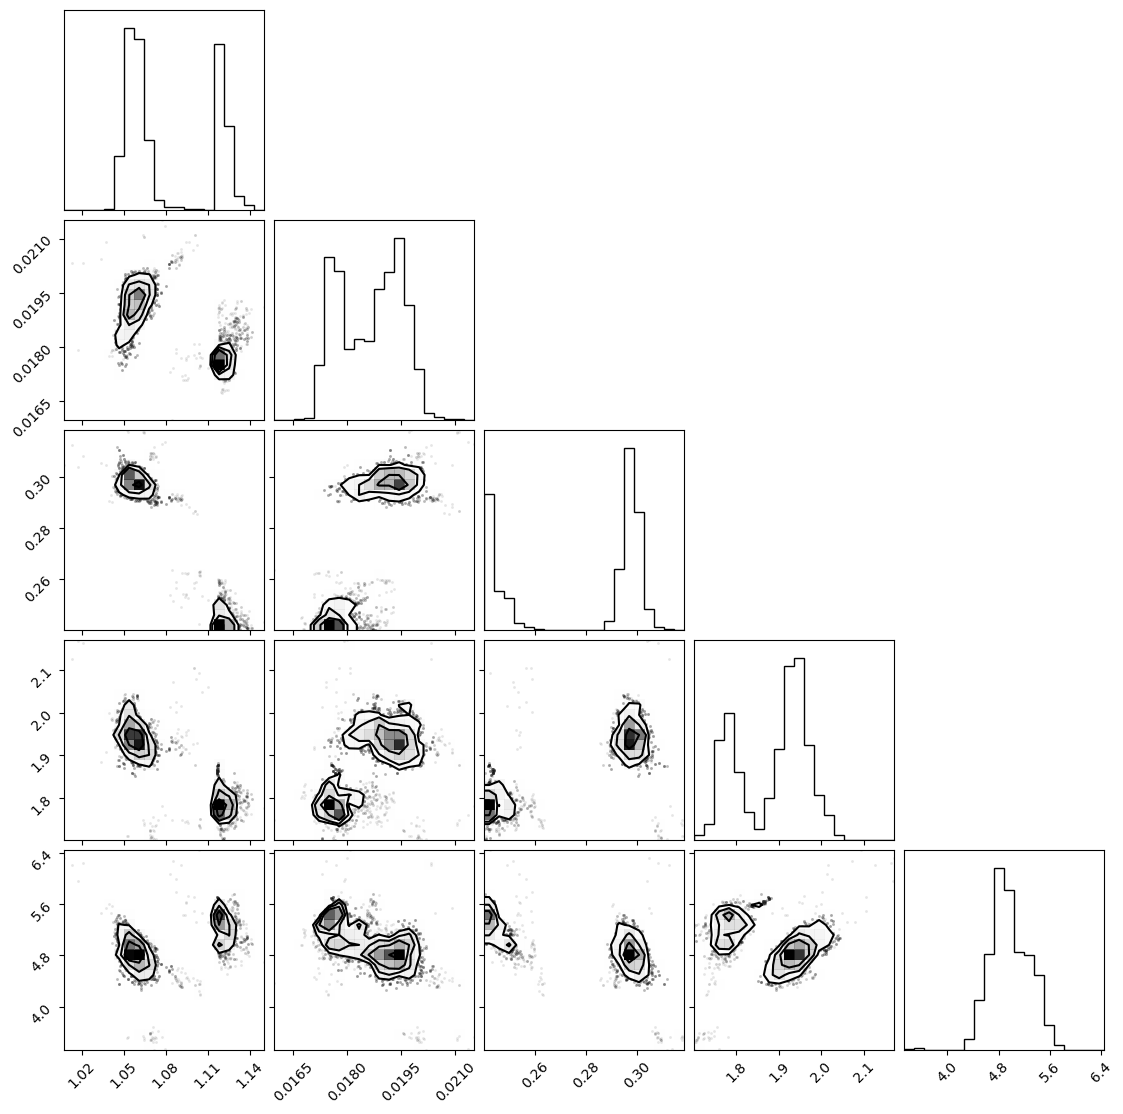

In [15]:
"""
run without emulator noise
"""

tic = time.time()
sampler = ns(priors=priors, observed_vals=obs, observed_unc=unc, pitchfork=pitchfork)
posterior = sampler(nlive=500,sample='rwalk', bound='multi')
toc = time.time()

corner.corner(posterior);

In [ ]:
corner.corner(posterior, truths=model_inps.values.flatten().tolist(), labels=model_inps.columns, color='red',show_titles=True,smooth=True);

In [ ]:
figure = corner.corner(prior_samples, truths=model_inps.values.flatten().tolist(), labels=model_inps.columns, color='blue',hist_kwargs={'density':True})

corner.corner(posterior, truths=model_inps.values.flatten().tolist(), labels=model_inps.columns, color='red',show_titles=True,smooth=True, fig=figure,hist_kwargs={'density':True});


In [ ]:
"""
run with emulator noise
"""

tic = time.time()
sampler = ns(priors=priors, observed_vals=obs, observed_unc=combined_unc, pitchfork=pitchfork)
posterior = sampler(nlive=250,sample='rwalk', bound='multi')
toc = time.time()

corner.corner(posterior);

corner.corner(posterior, truths=model_inps.values.flatten().tolist(), labels=model_inps.columns, color='red',show_titles=True,smooth=True);

figure = corner.corner(prior_samples, truths=model_inps.values.flatten().tolist(), labels=model_inps.columns, color='blue',hist_kwargs={'density':True})

corner.corner(posterior, truths=model_inps.values.flatten().tolist(), labels=model_inps.columns, color='red',show_titles=True,smooth=True, fig=figure,hist_kwargs={'density':True});


In [ ]:
"""
run with obs noise and emulator noise
"""

tic = time.time()
sampler = ns(priors=priors, observed_vals=noisy_obs, observed_unc=combined_unc, pitchfork=pitchfork)
posterior = sampler(nlive=250,sample='rwalk', bound='multi')
toc = time.time()

corner.corner(posterior);

In [ ]:
"""
run with obs noise added
"""
noisy_obs = obs_noise(obs,unc)

posteriors_dict = {'posterior_0' : posterior}

for i in range(1,5):
    print(f'current iteration: {i}', end='\r')
    noisy_obs = obs_noise(obs,unc)
    sampler = ns(priors=priors, observed_vals=noisy_obs, observed_unc=combined_unc, pitchfork=pitchfork)
    posterior_i = sampler(nlive=500,sample='rwalk', bound='multi')
    posteriors_dict[f'posterior_{i}'] = posterior_i
    

In [ ]:
idx = 0
for posterior_i in posteriors_dict:
    if idx == 0:
        figure = corner.corner(posteriors_dict[posterior_i], truths=model_inps.values.flatten().tolist(), labels=model_inps.columns, color='black',show_titles=True,smooth=True,hist_kwargs={'density':True})
    elif idx == len(posteriors_dict)-1:
        corner.corner(posteriors_dict[posterior_i], truths=model_inps.values.flatten().tolist(), labels=model_inps.columns, color='red',show_titles=True,smooth=True, fig=figure,hist_kwargs={'density':True})
    else:
        corner.corner(posteriors_dict[posterior_i], truths=model_inps.values.flatten().tolist(), labels=model_inps.columns, color='black',show_titles=True,smooth=True, fig=figure,hist_kwargs={'density':True})
    idx+=1

In [ ]:
figure = corner.corner(prior_samples, truths=model_inps.values.flatten().tolist(), labels=model_inps.columns, color='blue',hist_kwargs={'density':True})

idx = 0
for posterior_i in posteriors_dict:
    if idx == len(posteriors_dict)-1:
        corner.corner(posteriors_dict[posterior_i], truths=model_inps.values.flatten().tolist(), labels=model_inps.columns, color='red',show_titles=True,smooth=True, fig=figure,hist_kwargs={'density':True})
    else:
        corner.corner(posteriors_dict[posterior_i], truths=model_inps.values.flatten().tolist(), labels=model_inps.columns, color='black',show_titles=True,smooth=True, fig=figure,hist_kwargs={'density':True})
    idx+=1

In [ ]:
idx = 0
for posterior_i in posteriors_dict:
    if idx == 0:
        figure = corner.corner(posteriors_dict[posterior_i], truths=model_inps.values.flatten().tolist(), labels=model_inps.columns, color='black',show_titles=True,smooth=True,hist_kwargs={'density':True})
    elif idx == len(posteriors_dict)-1:
        corner.corner(posteriors_dict[posterior_i], truths=model_inps.values.flatten().tolist(), labels=model_inps.columns, color='red',show_titles=True,smooth=True, fig=figure,hist_kwargs={'density':True})
    else:
        corner.corner(posteriors_dict[posterior_i], truths=model_inps.values.flatten().tolist(), labels=model_inps.columns, color='black',show_titles=True,smooth=True, fig=figure,hist_kwargs={'density':True})
    idx+=1

In [ ]:
figure = corner.corner(prior_samples, truths=model_inps.values.flatten().tolist(), labels=model_inps.columns, color='blue',hist_kwargs={'density':True})

idx = 0
for posterior_i in posteriors_dict:
    if idx == len(posteriors_dict)-1:
        corner.corner(posteriors_dict[posterior_i], truths=model_inps.values.flatten().tolist(), labels=model_inps.columns, color='red',show_titles=True,smooth=True, fig=figure,hist_kwargs={'density':True})
    else:
        corner.corner(posteriors_dict[posterior_i], truths=model_inps.values.flatten().tolist(), labels=model_inps.columns, color='black',show_titles=True,smooth=True, fig=figure,hist_kwargs={'density':True})
    idx+=1

In [ ]:
len(posteriors_dict)

In [ ]:
figure = corner.corner(df[inputs].sample(n=posterior.shape[0]));
print(toc-tic)
prior_samples = np.array([mass_prior.rvs(size=posterior.shape[0]),Zinit_prior.rvs(size=posterior.shape[0]), Yinit_prior.rvs(size=posterior.shape[0]), MLT_prior.rvs(size=posterior.shape[0]), age_prior.rvs(size=posterior.shape[0])]).T
corner.corner(prior_samples, truths=model_inps.values.flatten().tolist(), labels=model_inps.columns, color='blue', fig=figure);
corner.corner(posterior, truths=model_inps.values.flatten().tolist(), labels=model_inps.columns, color='red', fig=figure);

In [ ]:
#prior_samples = np.array([mass_prior.rvs(size=posterior.shape[0]),Zinit_prior.rvs(size=posterior.shape[0]), Yinit_prior.rvs(size=posterior.shape[0]), MLT_prior.rvs(size=posterior.shape[0]), age_prior.rvs(size=posterior.shape[0])]).T
figure = corner.corner(prior_samples, truths=model_inps.values.flatten().tolist(), labels=model_inps.columns, color='blue',hist_kwargs={'density':True});
corner.corner(posterior, truths=model_inps.values.flatten().tolist(), labels=model_inps.columns, color='red', fig=figure,hist_kwargs={'density':True});
#hist_kwargs={'density'=True}

In [ ]:
corner.corner(posterior, truths=model_inps.values.flatten().tolist(), labels=model_inps.columns, color='red',show_titles=True,smooth=True);

In [ ]:
%timeit pitchfork.predict([[0.1,0.1,0.1,0.1,0.1]])

In [ ]:
pitchfork.predict([[0.1,0.1,0.1,0.1,0.1]])

In [ ]:
import pickle
file_path = "pickle jar/nu6-40_elu_nonorm"

with open(file_path+".pkl", 'rb') as fp:
    emulator_dict = pickle.load(fp)
    
custom_objects = {"InversePCA": InversePCA(emulator_dict['custom_objects']['inverse_pca']['pca_comps'], emulator_dict['custom_objects']['inverse_pca']['pca_mean']),"WMSE": WMSE(emulator_dict['custom_objects']['WMSE']['weights'])}

model = tf.keras.models.load_model(file_path+".h5", custom_objects=custom_objects)

In [ ]:
%timeit model(np.array([[0.1,0.1,0.1,0.1,0.1]]))